In [59]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
#from torchvision.transforms import functional as F
import torch.nn.functional as F
from PIL import Image
from roboflow import Roboflow
import matplotlib.pyplot as plt
import numpy as np
from lxml import etree, objectify
import os
from tqdm import tqdm
import cv2
import uuid
from datasets import (
    create_train_dataset, create_valid_dataset, 
    create_train_loader, create_valid_loader
)


In [2]:
rf = Roboflow(api_key="KhV6y3SVx0M66EFe23Vv")
project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
version = project.version(9)
dataset = version.download("voc")

loading Roboflow workspace...
loading Roboflow project...


In [3]:
# Paths to the image and annotation directories
train_images_path = '/teamspace/studios/this_studio/football-players-detection-9/train'
train_labels_path = '/teamspace/studios/this_studio/football-players-detection-9/train'
valid_images_path = '/teamspace/studios/this_studio/football-players-detection-9/valid'
valid_labels_path = '/teamspace/studios/this_studio/football-players-detection-9/valid'
test_images_path = '/teamspace/studios/this_studio/football-players-detection-9/test'
test_labels_path = '/teamspace/studios/this_studio/football-players-detection-9/test'

In [11]:
# Image dimensions
resize_width, resize_height = 640, 640

# Classes (ensure these are in the same order as used during training)
classes = ['__background__', 'ball', 'goalkeeper', 'player', 'referee']

datasets = []

In [12]:
# Create datasets
train_dataset = create_valid_dataset(
    train_images_path, train_labels_path, 
    resize_width, resize_height, classes
)

valid_dataset = create_valid_dataset(
    valid_images_path, valid_labels_path, 
    resize_width, resize_height, classes
)

test_dataset = create_valid_dataset(
    test_images_path, test_labels_path, 
    resize_width, resize_height, classes
)

datasets.extend([train_dataset, valid_dataset, test_dataset])



Got processor for bboxes, but no transform to process it.


In [6]:
use_cuda=True
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

In [7]:
# Load the state_dict
checkpoint = torch.load('/teamspace/studios/this_studio/FGSM/best_model.pth', map_location=device)

# Get the classes and classes number from the checkpoint
NUM_CLASSES = checkpoint['config']['NC']
CLASSES = checkpoint['config']['CLASSES']

# Create our model
model = fasterrcnn_resnet50_fpn_v2(num_classes = NUM_CLASSES, pretrained=False, coco_model=False)

# Load the state_dict into the model
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to device and evaluation mode
model.to(device).eval()

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [8]:
# Define the loss function
def loss_fn(outputs, target):
    #scores = outputs[0]['scores']
    predicted_boxes = outputs[0]['boxes']  # Predicted bounding boxes
    predicted_labels = outputs[0]['labels'].float()  # Predicted class labels
    predicted_scores = outputs[0]['scores']  # Confidence scores

    ground_truth_boxes = target['boxes']
    ground_truth_labels = target['labels'].float()
    ground_truth_scores = torch.ones(target['labels'].size(0))

    bbox_loss = F.smooth_l1_loss(predicted_boxes, ground_truth_boxes)
    obj_loss = F.binary_cross_entropy_with_logits(predicted_scores, ground_truth_scores)
    class_loss = F.binary_cross_entropy_with_logits(predicted_labels, ground_truth_labels)

    # Total loss
    total_loss = bbox_loss + obj_loss + class_loss
    return total_loss

In [9]:
# FGSM function to generate adversarial examples
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [10]:
def check_pred_target(output , target ,skip):
    output_shape = output[0]['labels'].shape[0]
    target_shape = target['labels'].shape[0]
    if output_shape != target_shape:
        if skip:
            return None
        else :
            return ''   
    else:
        if skip:
            return ''
        else:
            return None

In [61]:
def save_fgsm_image_label(output_dir, image, target, i, class_mapping):
    tensor = image.cpu().detach()
    # Remove the batch dimension and convert to NumPy array
    image = tensor.squeeze().numpy()
    # Transpose dimensions from (C, H, W) to (H, W, C)
    image = np.transpose(image, (1, 2, 0))
    # Convert values to [0, 255] for uint8 images
    image = (np.clip(image * 255, 0, 255)).astype(np.uint8)

    if i == 0:
        image_dir = os.path.join(output_dir, 'train')
    elif i == 1:
        image_dir = os.path.join(output_dir, 'valid')
    else:
        image_dir = os.path.join(output_dir, 'test')

    os.makedirs(image_dir, exist_ok=True)  
    
    # Generate a random image_name using UUID    
    random_filename = str(uuid.uuid4())
    image_name = random_filename + '.jpg'
    label_name = random_filename + '.xml'
    fsgm_image_path = os.path.join(image_dir, image_name)    
    fsgm_label_path = os.path.join(image_dir, label_name)    

    cv2.imwrite(fsgm_image_path, image)

    bboxes = target['boxes']
    class_labels = target['labels']

    # Create the XML annotation
    E = objectify.ElementMaker(annotate=False)
    anno_tree = E.annotation(
        E.folder(''),
        E.filename(fsgm_image_path),
        E.path(fsgm_image_path),
        E.source(
            E.database("Unknown")
        ),
        E.size(
            E.width(image.shape[1]),
            E.height(image.shape[0]),
            E.depth(image.shape[2])
        ),
        E.segmented(0),
    )
    
    for bbox, class_label in zip(bboxes, class_labels):
        xmin, ymin, xmax, ymax = bbox
        class_name = class_mapping[int(class_label)]
        obj = E.object(
            E.name(class_name),
            E.pose("Unspecified"),
            E.truncated(0),
            E.difficult(0),
            E.occluded(0),
            E.bndbox(
                E.xmin(int(xmin)),
                E.ymin(int(ymin)),
                E.xmax(int(xmax)),
                E.ymax(int(ymax))
            )
        )
        anno_tree.append(obj)

    etree.ElementTree(anno_tree).write(fsgm_label_path, pretty_print=True)

In [70]:
def create_adversarial_attack (epsilon, base_dir, output_dir, width, height, classes, class_mapping) :
    # Process the entire validation dataset
    adv_examples = []
    correct = 0
    i = 0
    for folder in ['train', 'valid', 'test']:
        image_dir = os.path.join(base_dir, folder)
        label_dir = os.path.join(base_dir, folder)
        dataset = create_valid_dataset(image_dir, label_dir, width, height, classes)
    
        for image , target in tqdm(dataset, desc=f'Processing adversarial attack in {folder} images'):
            image = image.to(device)
            image = image.unsqueeze(0)
            
            # Set requires_grad attribute of tensor. Important for Attack
            image.requires_grad = True
            # Forward pass the data through the model
            outputs = model(image)

            # Check if pred and target are the same to compute the loss or just skip
            result = check_pred_target(outputs , target, True)
            if result == None:
                continue

            # Calculate loss
            loss = loss_fn(outputs, target)  # Assuming loss function and model expect labels

            model.zero_grad()
            loss.backward()

            data_grad = image.grad.data
            adv_image = fgsm_attack(image, epsilon, data_grad)
            adv_outputs = model(adv_image)

            # Check if adv_pred and target are the same
            result = check_pred_target(adv_outputs , target, False)

            if result != None:
                # Means the adv_pred and target are not the same
                adv_examples.append(adv_image)
                save_fgsm_image_label(output_dir, adv_image, target, i, class_mapping)
            else :
                # Means the adv_pred and labels are the same
                correct +=1

        # Calculate final accuracy for this epsilon
        final_acc = correct/float(len(dataset))
        # Increment i to save the images and targets depending on which folder --> exp train/test/valid
        i += 1
    
        print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(dataset)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [71]:
accuracies = []
examples = []
#epsilons = [0, .05, .1, .15, .2, .25, .3]
epsilons = [.05, .1]

base_dir = '/teamspace/studios/this_studio/football-players-detection-9'
output_dir = '/teamspace/studios/this_studio/football-players-detection-9-rcnn-fgsm'

# Image dimensions
resize_width, resize_height = 1920, 1080

# Classes (ensure these are in the same order as used during training)
classes = ['__background__', 'ball', 'goalkeeper', 'player', 'referee']


class_mapping = {
    1: "ball",
    2: "goalkeeper",
    3: "player", 
    4: "referee"
}

# Run test for each epsilon
for eps in epsilons:
    acc, ex = create_adversarial_attack(eps, base_dir, output_dir, resize_width, resize_height, classes, class_mapping)
    accuracies.append(acc)
    examples.append(ex)

Processing:   2%|▏         | 4/250 [00:38<39:49,  9.71s/it]


KeyboardInterrupt: 

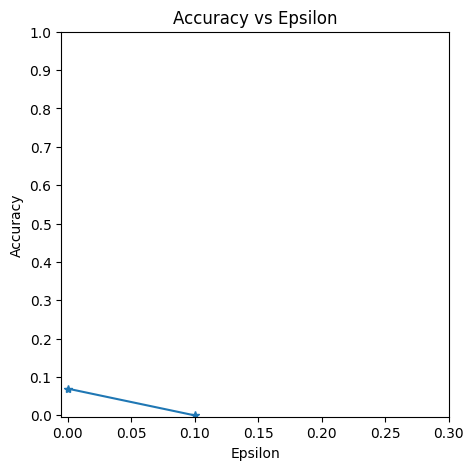

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [24]:
def show_image_tensor_pil(tensor):
    # Ensure the tensor is on CPU and detached from any computation graph
    tensor = tensor.cpu().detach()

    # Remove the batch dimension and convert to NumPy array
    image = tensor.squeeze().numpy()

    # Transpose dimensions from (C, H, W) to (H, W, C)
    image = np.transpose(image, (1, 2, 0))

    # Convert values to [0, 255] for uint8 images
    image = (np.clip(image * 255, 0, 255)).astype(np.uint8)

    # Convert NumPy array to PIL image
    pil_image = Image.fromarray(image)
    pil_image.show()

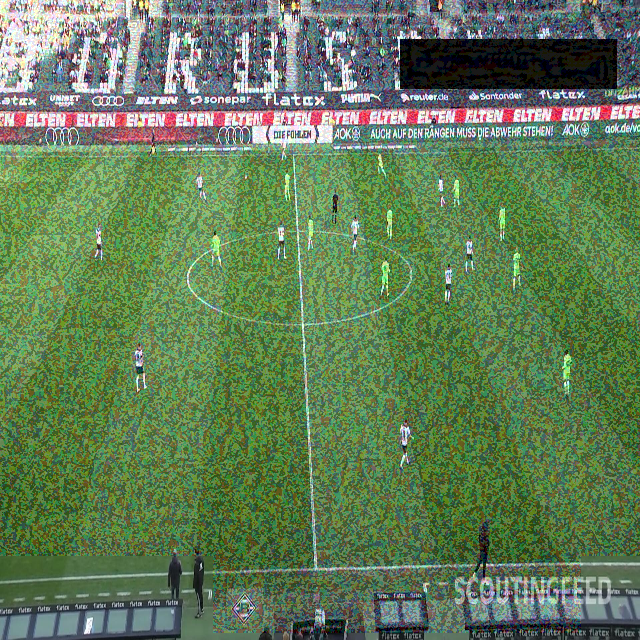

In [27]:
show_image_tensor_pil(examples[1][0])